In [2]:
#import tensorflow
import warnings

warnings.filterwarnings ('ignore')
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import tensorflow as tf 
from keras import backend as K

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam
from keras.utils.vis_utils import plot_model
from keras.wrappers.scikit_learn import KerasRegressor
import pandas as pd
import numpy as np
import math
import warnings
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
def calculate_adj_r2(r_sq, k, n):

    adj_r = 1-((1-r_sq)*(n-1)/(n-k-1))
   
    return adj_r

Using TensorFlow backend.


In [3]:
def LabelEncode(df_local):
    for col in df_local.columns:
        col_dict = {}
        if df_local[col].dtype!='object':
            continue
        elif df_local[col].dtype=='object':
            col2=df_local[col].unique()
            z=0
            for i in col2:
                col_dict[i]=z
                z+=1
            df_local[col]=df_local[col].map(col_dict)
        
            
    return df_local

data=pd.read_csv("auto-mpg.csv")
data.head()

print(data.columns)
data.fillna(0)
print(data.columns)
df_encode = LabelEncode(data)
df_encode.shape

X = ['cylinders', 'displacement', 'horsepower', 'weight',
        'model year', 'origin', 'car name' ]
#X=['weight', 'model year', 'origin']

Y = ['mpg']
# X_train, X_test, Y_train, Y_test = train_test_split(df_encode[X],df_encode[Y], test_size=0.25, random_state=42, shuffle=True)
# df_train=pd.concat([X_train, Y_train], axis=1).reindex(X_train.index)
# df_test=pd.concat([X_test, Y_test], axis=1).reindex(X_test.index)
# print(df_train.size)
# print(df_test.size)
X_train, X_test, Y_train, Y_test = train_test_split(df_encode[X],df_encode[Y], test_size=0.25, random_state=42, shuffle=True)


Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'model year', 'origin', 'car name'],
      dtype='object')
Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'model year', 'origin', 'car name'],
      dtype='object')


In [4]:
# Scale both training and testing input data

X_train = preprocessing.scale(X_train)

X_test = preprocessing.scale(X_test)

activation_list = ['linear','relu', 'sigmoid', 'tanh', 'elu','softmax','softplus','softsign','selu','exponential']


In [5]:

def r2_coeff(y_true, y_pred):
    SS_res =  tf.reduce_sum(tf.square(y_true - y_pred), axis=-1)
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true, axis=-1)), axis=-1)
    return (1 - SS_res/(SS_tot + tf.keras.backend.epsilon()))
    

def adj_r2(y_true, y_pred):
    SS_res =  tf.reduce_sum(tf.square(y_true - y_pred), axis=-1)
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true, axis=-1)), axis=-1)
    return (1 - (1 - r2_coeff(y_true, y_pred)) * (tf.cast(tf.size(y_true), tf.float32) - 1) / (tf.cast(tf.size(y_true), tf.float32) - tf.cast(tf.rank(y_true), tf.float32) - 1))

def adjusted_r2_score(r2, n, k):
    return 1-((1-r2)*(n-1)/(n-k-1))

In [6]:
def model_function(i, len_x):
    model = Sequential()
    model.add(Dense(len_x+1, input_dim=len_x, activation=i, kernel_initializer='normal'))
    model.add(Dense(len_x+1))
    model.add(Dense(len_x+1))

    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(optimizer='adam', loss='mae',  metrics = ['mse',r2_coeff, adj_r2]) 
    return model
    

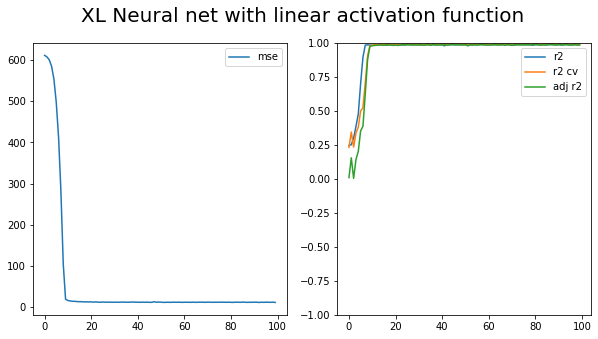

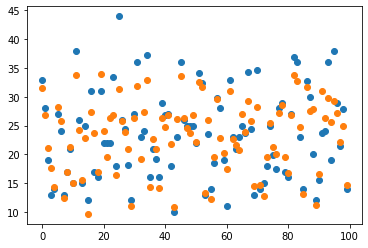

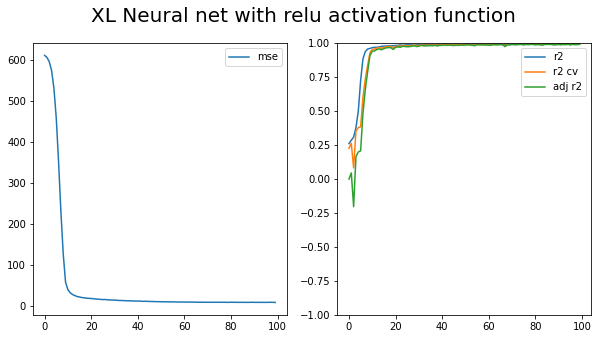

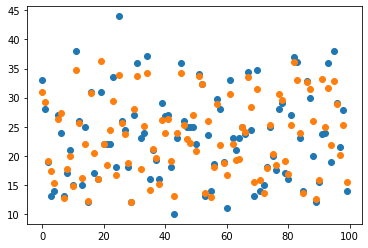

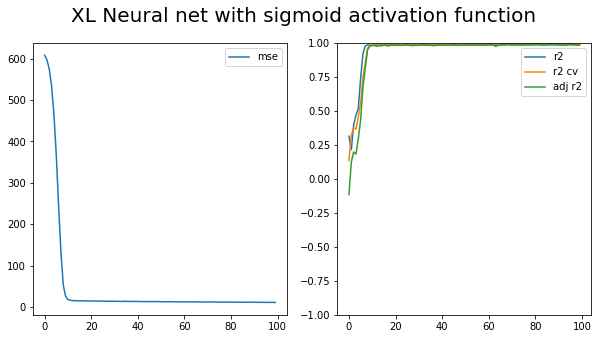

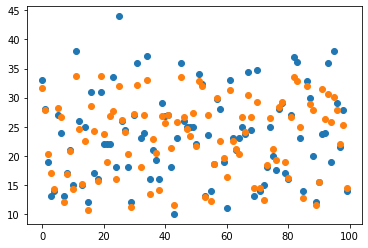

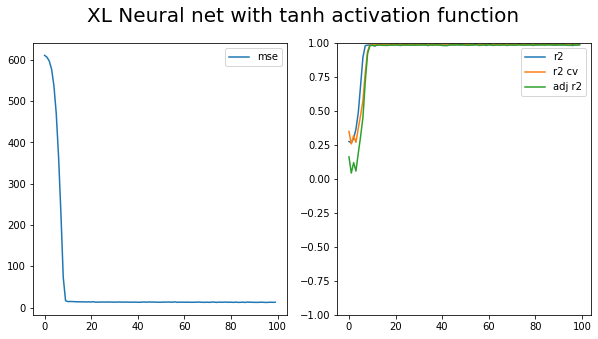

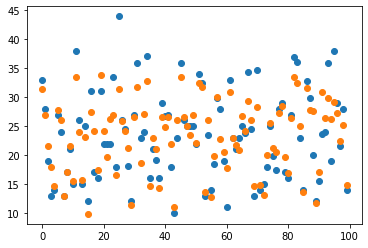

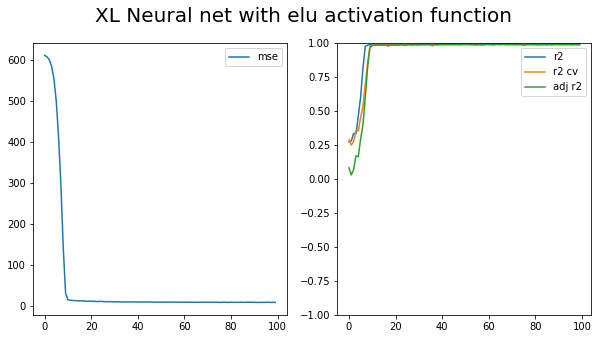

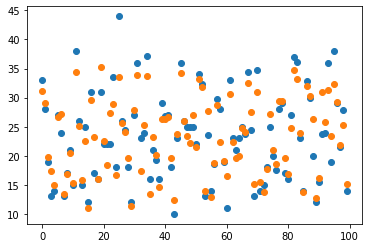

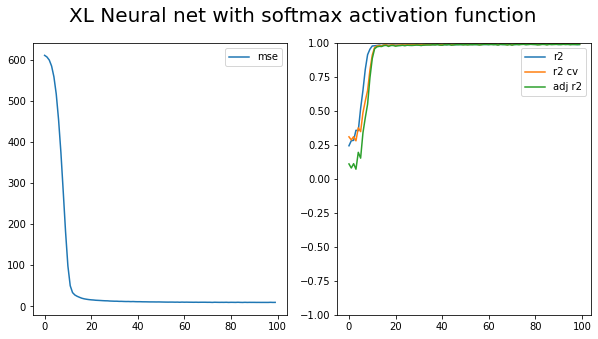

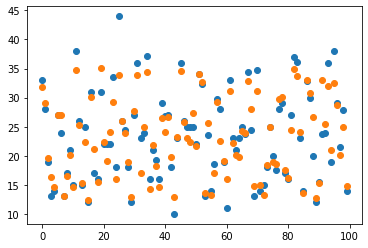

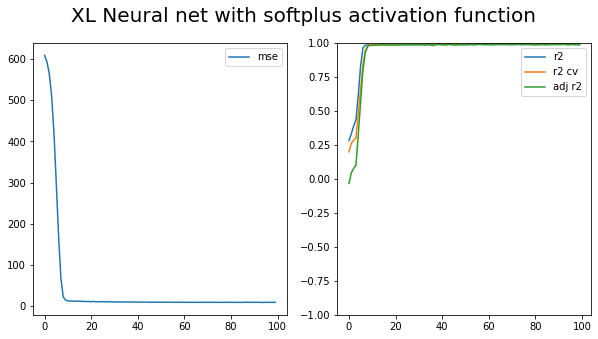

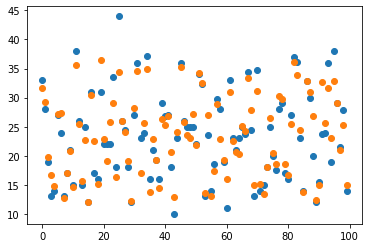

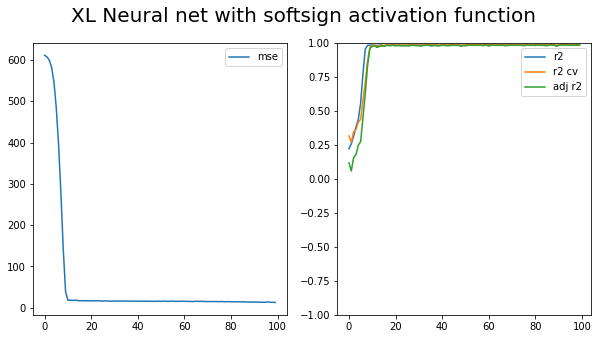

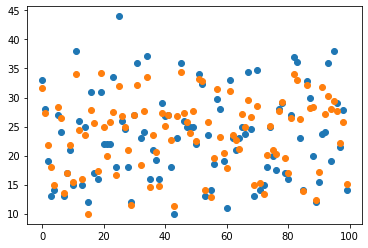

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


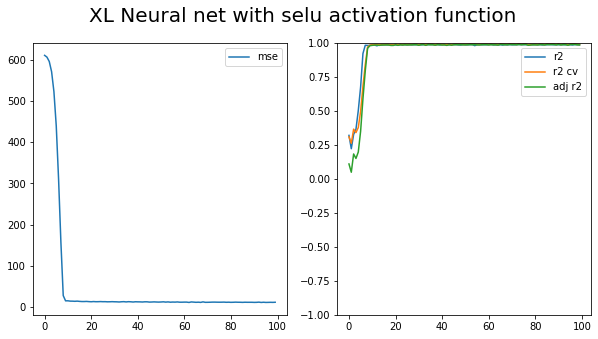

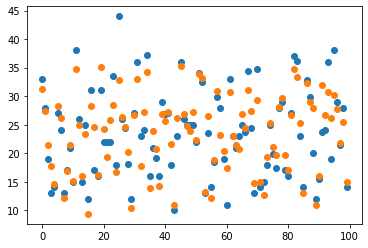

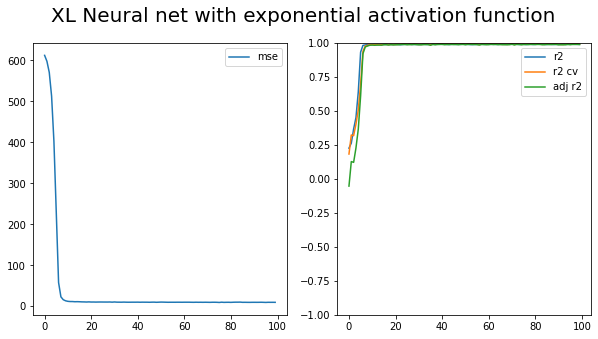

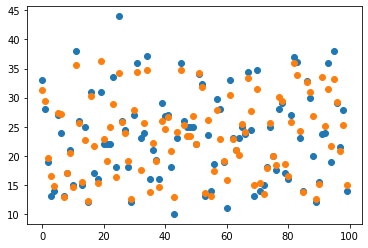

In [8]:
r2_list = []
r2_bar_list=[]
r2_scores_cv=[]
for i in activation_list:
    model_cv= model_function(i, len(X))
    model_r= model_function(i, len(X))
    model_cv_history = model_cv.fit(X_train, Y_train, epochs = 100, validation_split = 0.2,verbose = 0, batch_size=10)
    model_r_history = model_r.fit(X_train, Y_train, epochs = 100, verbose = 0, batch_size=10)

    #Plots model's training cost/loss and model's validation split cost/loss
    
    plt.subplots(1,2,figsize=(10,5))
    plt.suptitle("XL Neural net with "+i+" activation function", fontsize=20)
    plt.subplot(121)
    plt.plot( range(100), model_cv_history.history['mse'],label="mse")
    plt.legend()
    plt.subplot(122)
    plt.plot( range(100), model_r_history.history['r2_coeff'],label="r2")
    plt.plot( range(100), model_cv_history.history['r2_coeff'],label="r2 cv")
    plt.plot( range(100), model_cv_history.history['adj_r2'],label="adj r2")
    plt.ylim([-1, 1])
    plt.legend()
    plt.show()
    
    predict_y = model_r.predict(X_test)
    predict_y_cv = model_cv.predict(X_test)
    r2=r2_score(Y_test,predict_y)
    r2_list.append(r2)
    r2_bar_list.append(adjusted_r2_score(r2, X_train.shape[0],X_train.shape[1]-1))
    r2_scores_cv.append(r2_score(Y_test,predict_y_cv))
    #plt.figure()
#     plt.plot(loss_values,label='training loss')
#     plt.show()
    # Runs model (the one with the activation function, although this doesn't really matter as they perform the same) 
    # with its current weights on the training and testing data
   


    

    plt.scatter(x=range(len(X_test)), y=Y_test)
    plt.scatter(x=range(len(X_test)), y=predict_y_cv)
    plt.show()

   

In [9]:
print("Neural Net 4 Layers")
for i in range(len(activation_list)):
    #print("R2 value for using activation function %s : %s", activation_list[i], r2_list[i])
    print("Ad R2 value for using activation function %s : %s", activation_list[i], r2_bar_list[i])
    print("CV R2 value for using activation function %s : %s", activation_list[i], r2_scores_cv[i])

Neural Net 4 Layers
Ad R2 value for using activation function %s : %s linear 0.8298126371759401
CV R2 value for using activation function %s : %s linear 0.8209310440953819
Ad R2 value for using activation function %s : %s relu 0.878985235663654
CV R2 value for using activation function %s : %s relu 0.8766008762081066
Ad R2 value for using activation function %s : %s sigmoid 0.8502055465766132
CV R2 value for using activation function %s : %s sigmoid 0.835424649610176
Ad R2 value for using activation function %s : %s tanh 0.818298084525735
CV R2 value for using activation function %s : %s tanh 0.815122454870545
Ad R2 value for using activation function %s : %s elu 0.8682577834294845
CV R2 value for using activation function %s : %s elu 0.8700387671487798
Ad R2 value for using activation function %s : %s softmax 0.8982489722926753
CV R2 value for using activation function %s : %s softmax 0.8855251860660717
Ad R2 value for using activation function %s : %s softplus 0.8639240187095667
CV R

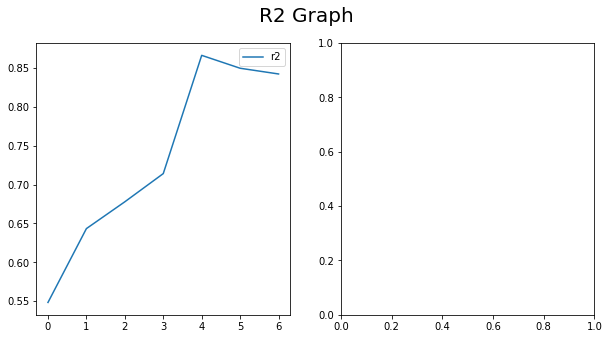

['cylinders', 'displacement', 'horsepower', 'weight', 'model year', 'origin', 'car name']


In [11]:
r2_list = []
r2_bar_list=[]
r2_cv_list=[]
col_list = []
updated_cols=[]
r_max=0
for i in X:
    col_list.append(i)

    model_cv = Sequential()    
    model_cv.add(Dense(13, input_dim=len(col_list), activation='relu'))
    model_cv.add(Dense(13))
    model_cv.add(Dense(13))
    model_cv.add(Dense(1))

    model_cv.compile(optimizer='adam', loss='mae', metrics=['mae']) 
    X_train = preprocessing.scale(df_encode[col_list])

    history = model_cv.fit(X_train, df_encode[Y], epochs = 100, validation_split = 0.2,verbose = 0, batch_size=10)
    history_dict=history.history
    y_test_pred = model_cv.predict(X_train)
    r2=r2_score(df_encode[Y], y_test_pred)
    if r2>r_max:
        r_max=r2
        updated_cols.append(i)
    r2_list.append(r2)
    adjusted_r2 = calculate_adj_r2(r2, X_train.shape[1],len(col_list))
    r2_bar_list.append(adjusted_r2)

    
plt.subplots(1,2,figsize=(10,5))
plt.suptitle("R2 Graph", fontsize=20)
plt.subplot(121)
plt.plot( range(len(col_list)), r2_list,label="r2")
plt.show()
    
    
print(col_list)